In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.nonparametric.kernel_regression import KernelReg
import seaborn as sns

In [2]:
def scatter_x_y(df, x_col, y_col, lowess_frac = 0.3, log_y = True, title: str = None):
    
    df = df.dropna(subset=[y_col, x_col])
    
    lowess = sm.nonparametric.lowess(df[y_col], df[x_col], frac=lowess_frac)
    X = df[x_col].values.reshape(-1, 1)
    ols_model = sm.OLS(df[y_col], sm.add_constant(X)).fit()
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    ax.scatter(df[x_col], df[y_col], c='blue', s=20, label='Data Points')
    ax.plot(X, ols_model.predict(sm.add_constant(X)), color='black', lw=2, label='OLS Fit')
    ax.plot(lowess[:, 0], lowess[:, 1], '--', color='black', lw=2, label='LOWESS')
    
    for _, row in df.iterrows():
        ax.text(row[x_col], row[y_col], fontsize=8, ha='right', va='bottom')
    
    ax.set_xlabel(f'{x_col}' )
    ax.set_ylabel(f"{y_col}")
    ax.set_title(title or f"Relationship: {y_col} vs {x_col}")
    ax.legend()
    
    return fig, ax

    


In [3]:
df = pd.read_csv('../Data for data description/DataAnalysisData.csv')

df['log_GDP'] =  np.log(df['GDP'])

df[f'hhd_change_previous_quarter'] = df.groupby('Country')['household_debt'].diff(periods= -1)
df[f'gdp_change_previous_quarter'] = df.groupby('Country')['log_GDP'].diff(periods= -1)
df[f'gdp_change_quarter'] = df.groupby('Country')['log_GDP'].diff(periods= 1)
df['hhd_change_quarter'] = df.groupby('Country')['household_debt'].diff(periods= 1)


for i in range(2,20):
    df[f'hhd_change_previous_quarter_t-{i}'] = df.groupby('Country')['hhd_change_previous_quarter'].shift(i).dropna()
    df[f'gdp_change_previous_quarter_t-{i}'] = df.groupby('Country')['gdp_change_previous_quarter'].shift(i).dropna()

for i in range(1,6):
    df[f'hhd_change_previous_{i}_year'] = df.groupby('Country')['household_debt'].diff(periods= -i*4)
    df[f'gdp_change_{i}_year'] = df.groupby('Country')['log_GDP'].diff(periods= i*4)

# df['hhd_change_one_year'] = df.groupby('Country')['household_debt'].diff(periods= -4)
# df['hhd_change_two_year'] = df.groupby('Country')['household_debt'].diff(periods= -8)
# df['hhd_change_three_year'] = df.groupby('Country')['household_debt'].diff(periods= -12)
# df['gdp_change_one_year'] = df.groupby('Country')['log_GDP'].diff(periods=4)
# df['gdp_change_two_year'] = df.groupby('Country')['log_GDP'].diff(periods=8)
# df['gdp_change_three_year'] = df.groupby('Country')['log_GDP'].diff(periods=12)

df['hhd_change_3_year'] = df.groupby('Country')['household_debt'].diff(periods= 12)



df['hhd_second_deriv_previous_1_year'] = df.groupby('Country')['hhd_change_previous_1_year'].diff(periods= -4)
df['hhd_second_deriv_previous_2_year'] = df.groupby('Country')['hhd_change_previous_2_year'].diff(periods= -4)
df['hhd_second_deriv_previous_3_year'] = df.groupby('Country')['hhd_change_previous_3_year'].diff(periods= -4)



df['gdp_second_deriv_1_year'] = df.groupby('Country')['gdp_change_1_year'].diff(periods=4)
df['gdp_second_deriv_2_year'] = df.groupby('Country')['gdp_change_2_year'].diff(periods=4)
df['gdp_second_deriv_3_year'] = df.groupby('Country')['gdp_change_3_year'].diff(periods=4)

# df['fe_hhd'] = df['hhd_change_1_year']- df.groupby('Country')['hhd_change_1_year'].transform('mean')
# df['fe_gdp'] = df['gdp_change_1_year'] - df.groupby('Country')['gdp_change_1_year'].transform('mean')


usa = df[df['Country'] == 'Norway']
usa = usa[['TIME_PERIOD', 'log_GDP', 'gdp_change_1_year', 'household_debt', 'hhd_change_previous_3_year']]

In [5]:
def plot_relationship_binned(df, x_var, y_var, num_buckets=50, 
                              lowess_fraction=0.3, figsize=(10, 6),
                              plot_title=None, scatter_color='blue',
                              scatter_size=50, line_width=2):
    
    bin_var_name = f"{x_var}_Bin"
    df_copy = df.copy()
    df_copy[bin_var_name] = pd.qcut(df_copy[x_var], num_buckets, duplicates='drop')
    
    bucket_summary = df_copy.groupby(bin_var_name).agg(
        {y_var: 'mean', x_var: 'mean'}
    ).reset_index()
    
    df_copy = df_copy[[x_var, y_var]].dropna()
    lowess_result = sm.nonparametric.lowess(
        df_copy[y_var], 
        df_copy[x_var], 
        frac=lowess_fraction
    )
    
    X = df_copy[x_var].values.reshape(-1, 1)
    y = df_copy[y_var]
    model = sm.OLS(y, sm.add_constant(X)).fit()
    
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.scatter(
        bucket_summary[x_var], 
        bucket_summary[y_var],
        c=scatter_color, 
        label='Binned Data Points', 
        s=scatter_size, 
        marker='o'
    )

    ax.plot(
        X, 
        model.predict(sm.add_constant(X)), 
        color='black', 
        lw=line_width, 
        label=f'OLS Slope {model.params["x1"]:.3f}',
    )
    
    ax.plot(
        lowess_result[:, 0], 
        lowess_result[:, 1], 
        linestyle='--', 
        color='black', 
        label='Lowess Smoothing', 
        lw=line_width
    )
    
    x_label = x_var.replace('_', ' ').title()
    y_label = y_var.replace('_', ' ').title()
    
    ax.set_xlabel(f"{x_label} (Binned)")
    ax.set_ylabel(f"{y_label}")
    ax.legend()
    
    if plot_title:
        ax.set_title(plot_title)
    else:
        ax.set_title(f"{y_label} vs {x_label} (Binned)")

  
# scatter_x_y(df,  'hhd_second_deriv_three_year', 'gdp_change_three_year')



/var/folders/mg/jjtr9hhj5zj6g0svf83l817h0000gn/T/ipykernel_6227/3093413784.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_summary = df_copy.groupby(bin_var_name).agg(


(4862, 2)


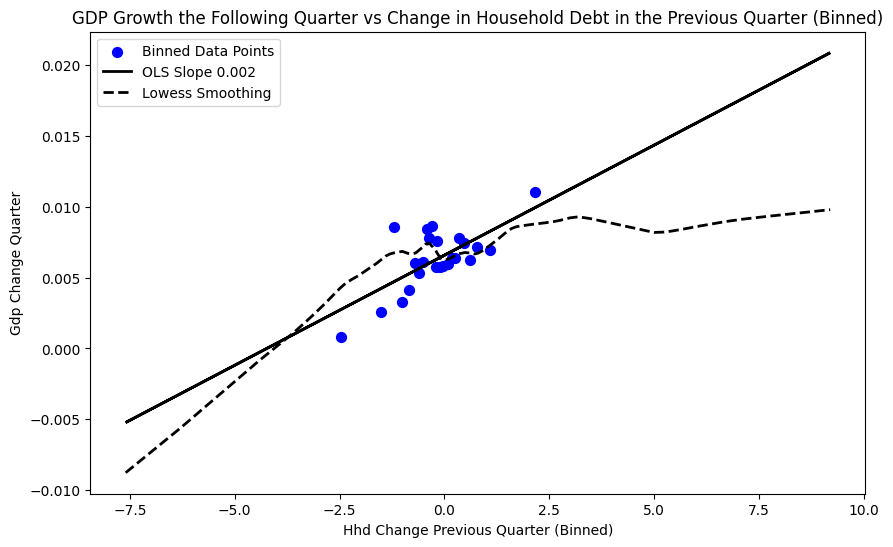

In [23]:
plot_relationship_binned(
    df=df,
    x_var='hhd_change_previous_quarter', 
    y_var='gdp_change_quarter',
    plot_title="GDP Growth the Following Quarter vs Change in Household Debt in the Previous Quarter (Binned)",
    num_buckets = 25,
)

df_copy = df.copy()

df_copy = df_copy[['hhd_change_previous_quarter','gdp_change_quarter']]
df_copy = df_copy.dropna()

print(df_copy.shape)

/var/folders/mg/jjtr9hhj5zj6g0svf83l817h0000gn/T/ipykernel_6227/3093413784.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_summary = df_copy.groupby(bin_var_name).agg(


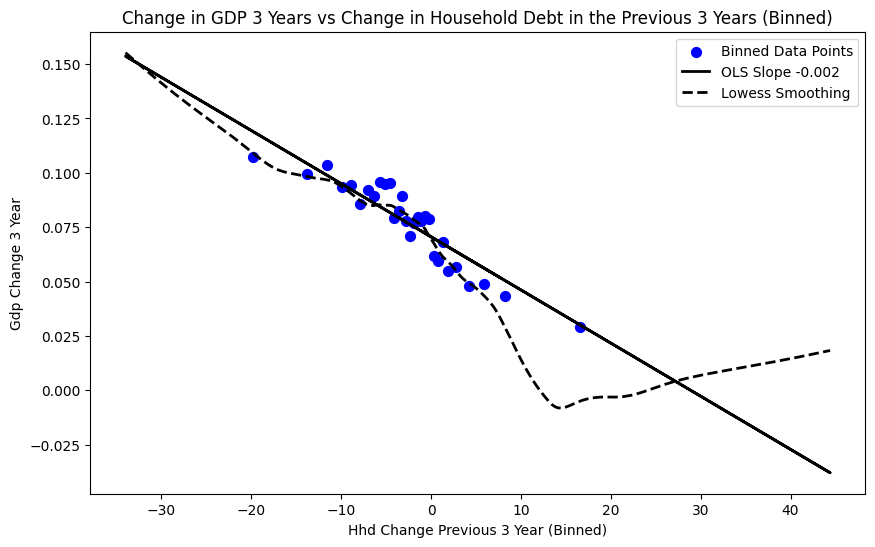

In [14]:
plot_relationship_binned(
    df=df,
    x_var='hhd_change_previous_3_year', 
    y_var='gdp_change_3_year',
    plot_title="Change in GDP 3 Years vs Change in Household Debt in the Previous 3 Years (Binned)",
    num_buckets = 30,
)

/var/folders/mg/jjtr9hhj5zj6g0svf83l817h0000gn/T/ipykernel_6227/3093413784.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_summary = df_copy.groupby(bin_var_name).agg(


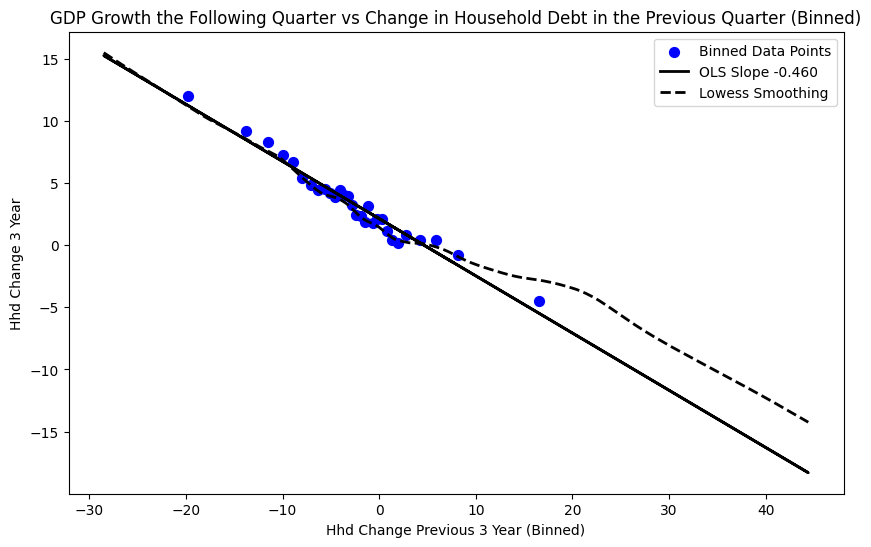

In [8]:
plot_relationship_binned(
    df= df,
    x_var='hhd_change_previous_3_year', 
    y_var='hhd_change_3_year',
    plot_title="GDP Growth the Following Quarter vs Change in Household Debt in the Previous Quarter (Binned)",
    num_buckets = 30,
)

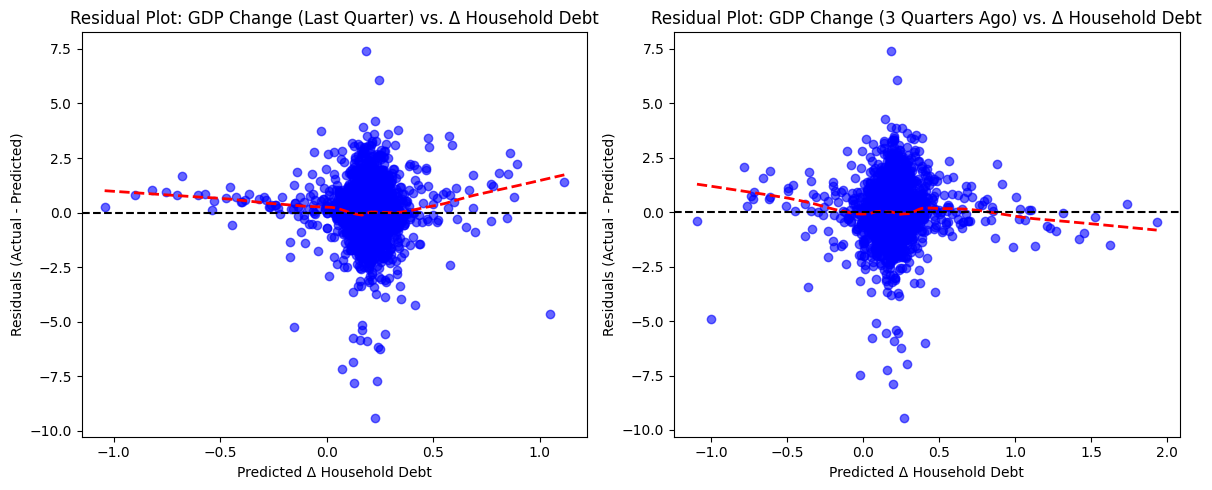

In [11]:
df_copy = df.copy()

df_copy = df_copy[['gdp_change_previous_quarter_t-3', 'hhd_change_quarter', 'gdp_change_previous_quarter']].dropna()

X1 = df_copy['gdp_change_previous_quarter'].values.reshape(-1, 1)
y1 = df_copy['hhd_change_quarter']
model1 = sm.OLS(y1, sm.add_constant(X1)).fit()
residuals1 = model1.resid
lowess_result1 = sm.nonparametric.lowess(residuals1, model1.fittedvalues, frac=0.3)

X2 = df_copy['gdp_change_previous_quarter_t-3'].values.reshape(-1, 1)
y2 = df_copy['hhd_change_quarter']
model2 = sm.OLS(y2, sm.add_constant(X2)).fit()
residuals2 = model2.resid
lowess_result2 = sm.nonparametric.lowess(residuals2, model2.fittedvalues, frac=0.3)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(model1.fittedvalues, residuals1, color='blue', alpha=0.6)
axes[0].plot(
    lowess_result1[:, 0], 
    lowess_result1[:, 1], 
    linestyle='--', 
    color='red', 
    label='Lowess Smoothing', 
    lw=2
)
axes[0].axhline(y=0, color='black', linestyle='--')
axes[0].set_xlabel("Predicted Δ Household Debt")
axes[0].set_ylabel("Residuals (Actual - Predicted)")
axes[0].set_title("Residual Plot: GDP Change (Last Quarter) vs. Δ Household Debt")


axes[1].scatter(model2.fittedvalues, residuals2, color='blue', alpha=0.6)
axes[1].plot(
    lowess_result2[:, 0], 
    lowess_result2[:, 1], 
    linestyle='--', 
    color='red', 
    label='Lowess Smoothing', 
    lw=2
)
axes[1].axhline(y=0, color='black', linestyle='--')
axes[1].set_xlabel("Predicted Δ Household Debt")
axes[1].set_ylabel("Residuals (Actual - Predicted)")
axes[1].set_title("Residual Plot: GDP Change (3 Quarters Ago) vs. Δ Household Debt")


plt.tight_layout()
plt.show()

In [ ]:

GDP_LAG = 12
HHD_LAG = 12
Price_LAG = HHD_LAG

df = df.reset_index()
df.sort_values(by=['Country', 'TIME_PERIOD'], inplace=True)

df['lnGDP'] = np.log(df['GDP'])
df['GDP_growth'] = df.groupby('Country')['lnGDP'].diff(periods= GDP_LAG )
df['household_debt_GDP_change'] = df.groupby('Country')['household_debt'].shift(-1) - df.groupby('Country')['household_debt'].shift(-HHD_LAG)

df = df.dropna(subset=['GDP_growth', 'household_debt_GDP_change'])
df[df['Country'] == 'United States']
df['housing_price_lagged'] = df.groupby('Country')['housing_price'].shift(Price_LAG)

df = df.dropna(subset=['housing_price_lagged'])

lowess_result = sm.nonparametric.lowess(df['GDP_growth'], df['household_debt_GDP_change'], frac=0.3)
df['GDP_growth_lowess'] = np.interp(df['household_debt_GDP_change'], lowess_result[:, 0], lowess_result[:, 1])

df = df.sort_values('household_debt_GDP_change')


fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(df['household_debt_GDP_change'], df['GDP_growth'], 
                     c=df['housing_price_lagged'], cmap='viridis', label='Data Points', s=20, marker='o')

X = df['household_debt_GDP_change'].values.reshape(-1, 1)
y = df['GDP_growth']
model = sm.OLS(y, sm.add_constant(X)).fit()


ax.plot(df['household_debt_GDP_change'], model.predict(sm.add_constant(df['household_debt_GDP_change'].values.reshape(-1, 1))), 
        color='black', lw=2, label='OLS Fit')

ax.plot(lowess_result[:, 0], lowess_result[:, 1], linestyle='--', color='black', label='Lowess Smoothing', lw=2)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(f'Lagged Housing Price Index (t-{Price_LAG})')

ax.set_xlabel(f"Change in Household Debt to GDP (t-{HHD_LAG} to t-1)")
ax.set_ylabel(f"GDP Growth (t to t+{GDP_LAG}")
ax.legend()
ax.set_title("Panel A: GDP Growth vs Household Debt Change (Lagged Housing Affordability)")

plt.show()

ValueError: cannot insert level_0, already exists

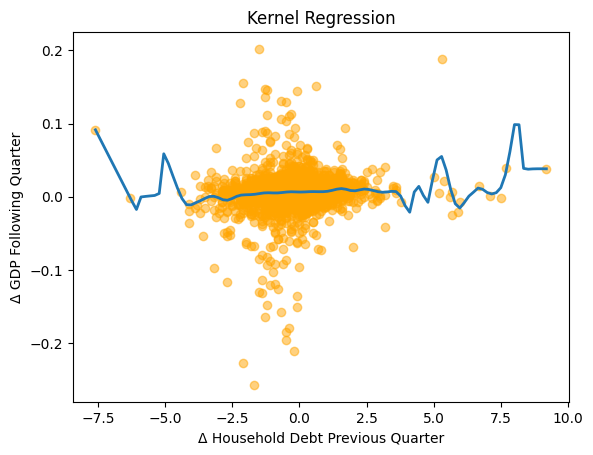

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kernel_regression import KernelReg

df_copy = df.copy()
df_copy = df_copy[['hhd_change_previous_quarter','gdp_change_quarter']]
df_copy = df_copy.dropna()
x = np.array(df_copy['hhd_change_previous_quarter']).flatten()
y = np.array(df_copy['gdp_change_quarter']).flatten()
kr = KernelReg(
    endog=y,
    exog=x.reshape(-1, 1),
    var_type='c',  
    reg_type='ll', 
    bw='cv_ls', 
    ckertype='gaussian'
)

x_min, x_max = x.min(), x.max()
x_grid = np.linspace(x_min, x_max, 100)

y_pred, y_std = kr.fit(x_grid.reshape(-1, 1))
fig, ax = plt.subplots()

ax.scatter(x, y, alpha=0.5, color="orange")
ax.set_xlabel('Δ Household Debt Previous Quarter')
ax.set_ylabel('Δ GDP Following Quarter')
ax.set_title('Kernel Regression')
ax.plot(x_grid, y_pred, linewidth=2, label='Kernel Regression')
plt.show()







(<Figure size 1000x600 with 1 Axes>,
 array([-34.        , -33.20808081, -32.41616162, -31.62424242,
        -30.83232323, -30.04040404, -29.24848485, -28.45656566,
        -27.66464646, -26.87272727, -26.08080808, -25.28888889,
        -24.4969697 , -23.70505051, -22.91313131, -22.12121212,
        -21.32929293, -20.53737374, -19.74545455, -18.95353535,
        -18.16161616, -17.36969697, -16.57777778, -15.78585859,
        -14.99393939, -14.2020202 , -13.41010101, -12.61818182,
        -11.82626263, -11.03434343, -10.24242424,  -9.45050505,
         -8.65858586,  -7.86666667,  -7.07474747,  -6.28282828,
         -5.49090909,  -4.6989899 ,  -3.90707071,  -3.11515152,
         -2.32323232,  -1.53131313,  -0.73939394,   0.05252525,
          0.84444444,   1.63636364,   2.42828283,   3.22020202,
          4.01212121,   4.8040404 ,   5.5959596 ,   6.38787879,
          7.17979798,   7.97171717,   8.76363636,   9.55555556,
         10.34747475,  11.13939394,  11.93131313,  12.72323232,
   

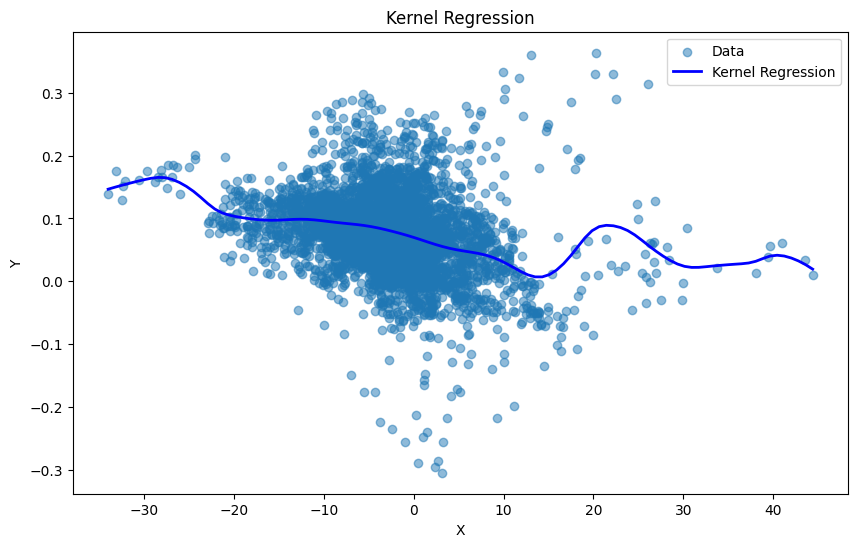

In [ ]:
kernel_regression_plot('hhd_change_previous_3_year', 'gdp_change_3_year')